
Fully Convolutional Network (FCN) for Semantic Segmentation
============================================================
This notebook implements FCN variants with different upsampling strategies
and compares their performance on a semantic segmentation task.


In [15]:
import os, random, math, time, json
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import torchvision
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
from typing import Tuple, Dict, List
from tqdm import tqdm
import pandas as pd

In [24]:
# --- Configuration for Pascal VOC 2012 ---

class CFG:
    # Data
    root = './data/voc2012'             # main folder containing 'images' and 'masks'
    use_synthetic = False               # using VOC dataset
    num_classes = 21                    # Pascal VOC = 20 object classes + background
    class_names = [
        'background','aeroplane','bicycle','bird','boat','bottle',
        'bus','car','cat','chair','cow','diningtable','dog','horse',
        'motorbike','person','pottedplant','sheep','sofa','train','tvmonitor'
    ]

    # Paths for Pascal VOC dataset
    images_dir = './data/voc2012/images'   # all .jpg images
    masks_dir  = './data/voc2012/masks'    # all .png masks (will need color → class index conversion)

    # Train/Test split
    train_ratio = 0.8                      # 80% train, 20% test

    # Training
    epochs = 20
    batch_size = 4                         # adjust per GPU memory
    lr = 1e-3
    optimizer = 'adam'                     # 'adam' or 'sgd'
    weight_decay = 1e-4
    seed = 1337

    # Model
    backbone = 'resnet18'                  # backbone for feature extraction
    use_pretrained = True
    variant = 'fcn8s'                      # FCN variant: 'fcn32s', 'fcn16s', 'fcn8s'

    # Augmentation / Preprocessing
    image_size = 256                       # resize images for faster training
    mean = [0.485, 0.456, 0.406]
    std  = [0.229, 0.224, 0.225]

# Set random seeds for reproducibility
random.seed(CFG.seed)
np.random.seed(CFG.seed)
torch.manual_seed(CFG.seed)

# Create root folder (safe if already exists)
os.makedirs(CFG.root, exist_ok=True)

print("Pascal VOC Configuration Loaded:")
for k,v in CFG.__dict__.items():
    if not k.startswith('__'):
        print(f"{k:15s} = {v}")


Pascal VOC Configuration Loaded:
root            = ./data/voc2012
use_synthetic   = False
num_classes     = 21
class_names     = ['background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']
images_dir      = ./data/voc2012/images
masks_dir       = ./data/voc2012/masks
train_ratio     = 0.8
epochs          = 20
batch_size      = 4
lr              = 0.001
optimizer       = adam
weight_decay    = 0.0001
seed            = 1337
backbone        = resnet18
use_pretrained  = True
variant         = fcn8s
image_size      = 256
mean            = [0.485, 0.456, 0.406]
std             = [0.229, 0.224, 0.225]


In [25]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)

# ---------------------------
# 1) Convert Pascal VOC color masks -> index masks (0..20)
# ---------------------------
VOC_COLORMAP = [
    (0, 0, 0), (128, 0, 0), (0, 128, 0), (128, 128, 0),
    (0, 0, 128), (128, 0, 128), (0, 128, 128), (128, 128, 128),
    (64, 0, 0), (192, 0, 0), (64, 128, 0), (192, 128, 0),
    (64, 0, 128), (192, 0, 128), (64, 128, 128), (192, 128, 128),
    (0, 64, 0), (128, 64, 0), (0, 192, 0), (128, 192, 0),
    (0, 64, 128)
]
# create mapping from packed int -> index
_color_to_index = { (r<<16) | (g<<8) | b : idx for idx,(r,g,b) in enumerate(VOC_COLORMAP) }

def convert_and_save_masks(color_masks_dir, out_dir):
    """Convert color-coded Pascal VOC masks into single-channel index PNGs."""
    os.makedirs(out_dir, exist_ok=True)
    filenames = sorted([f for f in os.listdir(color_masks_dir) if f.lower().endswith('.png')])
    print(f"Converting {len(filenames)} masks -> {out_dir}")
    for nm in tqdm(filenames):
        src = os.path.join(color_masks_dir, nm)
        dst = os.path.join(out_dir, nm)  # same filename, but index-coded
        img = Image.open(src).convert('RGB')
        arr = np.array(img, dtype=np.uint8)
        codes = (arr[:,:,0].astype(np.uint32) << 16) | (arr[:,:,1].astype(np.uint32) << 8) | arr[:,:,2].astype(np.uint32)
        # map codes to indices with default 0 (background) if unknown
        idx_mask = np.zeros_like(codes, dtype=np.uint8)
        # vectorized mapping using dict lookup via numpy vectorize (ok for ~3k masks)
        # using python loop on unique codes for faster mapping
        unique_codes = np.unique(codes)
        for uc in unique_codes:
            idx = _color_to_index.get(int(uc), 0)
            idx_mask[codes == uc] = idx
        # save as single-channel PNG (mode 'L')
        Image.fromarray(idx_mask).save(dst)

# run conversion only if masks_idx directory doesn't already exist (safety)
masks_idx_dir = os.path.join(os.path.dirname(CFG.masks_dir), 'masks_idx')  # e.g. ./data/voc2012/masks_idx
if not os.path.exists(masks_idx_dir) or len(os.listdir(masks_idx_dir)) < 10:
    convert_and_save_masks(CFG.masks_dir, masks_idx_dir)
else:
    print("Found existing masks_idx, skipping conversion:", masks_idx_dir)

# point dataset to masks_idx
images_dir = CFG.images_dir
masks_dir  = masks_idx_dir

Device: cuda
Found existing masks_idx, skipping conversion: ./data/voc2012/masks_idx


In [26]:
# 2) Dataset class (Pascal-ready)
class SegDataset(Dataset):
    def __init__(self, images_dir, masks_dir, size, mean, std, files=None):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.size = size
        self.mean = mean
        self.std = std

        all_files = sorted([f for f in os.listdir(images_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
        if files is None:
            self.files = all_files
        else:
            self.files = files

        self.img_tf = transforms.Compose([
            transforms.Resize((size, size), interpolation=Image.BILINEAR),
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])
        self.mask_resize = transforms.Resize((size, size), interpolation=Image.NEAREST)

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        name = self.files[idx]
        img_path = os.path.join(self.images_dir, name)
        mask_name = name.rsplit('.',1)[0] + '.png'
        mask_path = os.path.join(self.masks_dir, mask_name)

        img = Image.open(img_path).convert('RGB')
        mask = Image.open(mask_path).convert('L')  # already index-coded

        img = self.img_tf(img)
        mask = self.mask_resize(mask)
        mask = torch.from_numpy(np.array(mask, dtype=np.int64))
        return img, mask

In [27]:
# ---------------------------
# 3) Train/test split 
# ---------------------------
all_images = sorted([f for f in os.listdir(images_dir) if f.lower().endswith(('.jpg','.jpeg','.png'))])
masks_set = set([os.path.splitext(f)[0] for f in os.listdir(masks_dir) if f.lower().endswith('.png')])
# keep only images that have mask
paired = [f for f in all_images if os.path.splitext(f)[0] in masks_set]
print(f"Found {len(all_images)} images, {len(masks_set)} masks, {len(paired)} paired examples used for training.")

random.shuffle(paired)
paired = paired[:50]
n_train = int(len(paired) * CFG.train_ratio)
train_files = paired[:n_train]
test_files  = paired[n_train:]
print(len(paired))

train_ds = SegDataset(images_dir, masks_dir, CFG.image_size, CFG.mean, CFG.std, train_files)
test_ds  = SegDataset(images_dir, masks_dir, CFG.image_size, CFG.mean, CFG.std, test_files)

train_loader = DataLoader(train_ds, batch_size=CFG.batch_size, shuffle=True, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=1, shuffle=False, num_workers=1, pin_memory=True)

print("Train / Test sizes:", len(train_ds), len(test_ds))

# quick sanity visualize one example
x0, m0 = train_ds[0]
print("Sample shapes:", x0.shape, m0.shape, "unique mask labels:", torch.unique(m0))

Found 2913 images, 2913 masks, 2913 paired examples used for training.
50
Train / Test sizes: 40 10
Sample shapes: torch.Size([3, 256, 256]) torch.Size([256, 256]) unique mask labels: tensor([ 0,  7, 12])


In [28]:
# ---------------------------
# 4) Metrics helpers
# ---------------------------
def confusion_matrix(pred: torch.Tensor, target: torch.Tensor, num_classes: int):
    valid = (target >= 0) & (target < num_classes)
    pred = pred[valid]
    target = target[valid]
    hist = torch.bincount(num_classes * target + pred, minlength=num_classes**2).reshape(num_classes, num_classes)
    return hist

def compute_metrics(cm: torch.Tensor):
    tp = cm.diag().float()
    support = cm.sum(dim=1).float()
    pred_count = cm.sum(dim=0).float()
    union = support + pred_count - tp
    iou = tp / union.clamp(min=1e-6)
    miou = iou.mean().item()
    pixel_acc = tp.sum().item() / cm.sum().item()
    return {'mIoU': miou, 'pixel_acc': pixel_acc, 'per_class_iou': iou.cpu().numpy()}

def evaluate(model, loader, num_classes):
    model.eval()
    cm = torch.zeros((num_classes, num_classes), dtype=torch.int64)
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)
            logits = model(x)
            pred = logits.argmax(dim=1)
            for b in range(pred.shape[0]):
                cm += confusion_matrix(pred[b].cpu(), y[b].cpu(), num_classes)
    return compute_metrics(cm)

In [29]:
# ---------------------------
# 5) Model definitions (ResNet backbone + FCN heads)
# ---------------------------
class ResNetBackbone(nn.Module):
    def __init__(self, name='resnet18', pretrained=True):
        super().__init__()
        weights = None
        try:
            if pretrained:
                if name == 'resnet18':
                    weights = models.ResNet18_Weights.DEFAULT
                elif name == 'resnet34':
                    weights = models.ResNet34_Weights.DEFAULT
        except Exception as e:
            print("[WARN] pretrained not available:", e)
            weights = None

        if name == 'resnet18':
            net = models.resnet18(weights=weights)
        elif name == 'resnet34':
            net = models.resnet34(weights=weights)
        else:
            raise ValueError('backbone not supported')

        self.conv1 = net.conv1
        self.bn1 = net.bn1
        self.relu = net.relu
        self.maxpool = net.maxpool
        self.layer1 = net.layer1
        self.layer2 = net.layer2
        self.layer3 = net.layer3
        self.layer4 = net.layer4

    def forward(self, x):
        x = self.conv1(x); x = self.bn1(x); x = self.relu(x); x = self.maxpool(x)
        f4 = self.layer1(x)   # stride 4
        f8 = self.layer2(f4)  # stride 8
        f16 = self.layer3(f8) # stride 16
        f32 = self.layer4(f16) # stride 32
        return f8, f16, f32

class TransposeConvHead(nn.Module):
    def __init__(self, in32, in16, in8, num_classes, variant='fcn8s'):
        super().__init__()
        self.variant = variant
        self.score32 = nn.Conv2d(in32, num_classes, 1)
        if variant in ['fcn8s','fcn16s']:
            self.score16 = nn.Conv2d(in16, num_classes, 1)
        if variant == 'fcn8s':
            self.score8 = nn.Conv2d(in8, num_classes, 1)

        self.up32_to_16 = nn.ConvTranspose2d(num_classes, num_classes, kernel_size=4, stride=2, padding=1, bias=False)
        self.up16_to_8  = nn.ConvTranspose2d(num_classes, num_classes, kernel_size=4, stride=2, padding=1, bias=False)
        self.up8_to_1   = nn.ConvTranspose2d(num_classes, num_classes, kernel_size=16, stride=8, padding=4, bias=False)
        self.up32_to_1  = nn.ConvTranspose2d(num_classes, num_classes, kernel_size=64, stride=32, padding=16, bias=False)
        self.up16_to_1  = nn.ConvTranspose2d(num_classes, num_classes, kernel_size=32, stride=16, padding=8, bias=False)

    def forward(self, feats):
        f8, f16, f32 = feats
        s32 = self.score32(f32)
        if self.variant == 'fcn32s':
            return self.up32_to_1(s32)

        s32_up = self.up32_to_16(s32)
        s16 = self.score16(f16)
        s16_fused = s16 + s32_up

        if self.variant == 'fcn16s':
            return self.up16_to_1(s16_fused)

        s16_up = self.up16_to_8(s16_fused)
        s8 = self.score8(f8)
        s8_fused = s8 + s16_up

        out = self.up8_to_1(s8_fused)
        return out

class BilinearHead(nn.Module):
    def __init__(self, in32, in16, in8, num_classes, variant='fcn8s'):
        super().__init__()
        self.variant = variant
        self.score32 = nn.Conv2d(in32, num_classes, 1)
        if variant in ['fcn8s','fcn16s']:
            self.score16 = nn.Conv2d(in16, num_classes, 1)
        if variant == 'fcn8s':
            self.score8 = nn.Conv2d(in8, num_classes, 1)

    def forward(self, feats, out_size):
        f8, f16, f32 = feats
        s32 = self.score32(f32)
        if self.variant == 'fcn32s':
            return F.interpolate(s32, size=out_size, mode='bilinear', align_corners=False)

        s32_up = F.interpolate(s32, size=f16.shape[-2:], mode='bilinear', align_corners=False)
        s16 = self.score16(f16)
        s16_fused = s16 + s32_up

        if self.variant == 'fcn16s':
            return F.interpolate(s16_fused, size=out_size, mode='bilinear', align_corners=False)

        s16_up = F.interpolate(s16_fused, size=f8.shape[-2:], mode='bilinear', align_corners=False)
        s8 = self.score8(f8)
        s8_fused = s8 + s16_up

        return F.interpolate(s8_fused, size=out_size, mode='bilinear', align_corners=False)

class FCN(nn.Module):
    def __init__(self, backbone_name='resnet18', pretrained=True, num_classes=21, variant='fcn8s', upsample='transpose'):
        super().__init__()
        self.backbone = ResNetBackbone(backbone_name, pretrained=pretrained)
        ch8, ch16, ch32 = 128, 256, 512
        self.upsample_mode = upsample
        if upsample == 'transpose':
            self.head = TransposeConvHead(ch32, ch16, ch8, num_classes, variant=variant)
        elif upsample == 'bilinear':
            self.head = BilinearHead(ch32, ch16, ch8, num_classes, variant=variant)
        else:
            raise ValueError("upsample must be 'transpose' or 'bilinear'")

    def forward(self, x):
        feats = self.backbone(x)
        if self.upsample_mode == 'transpose':
            return self.head(feats)
        else:
            return self.head(feats, out_size=x.shape[-2:])

In [30]:
# ---------------------------
# 6) Training utilities
# ---------------------------
def make_optimizer(params, name='adam', lr=1e-3, wd=1e-4):
    if name.lower() == 'adam':
        return torch.optim.Adam(params, lr=lr, weight_decay=wd)
    elif name.lower() == 'sgd':
        return torch.optim.SGD(params, lr=lr, momentum=0.9, weight_decay=wd)
    else:
        raise ValueError('Unknown optimizer')

def train_one_epoch(model, loader, optim, criterion, num_classes):
    model.train()
    total_loss = 0.0
    cm = torch.zeros((num_classes, num_classes), dtype=torch.int64)
    pbar = tqdm(loader, desc="Train batches", leave=False)
    for x, y in pbar:
        x = x.to(device); y = y.to(device)
        optim.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optim.step()
        total_loss += loss.item() * x.size(0)

        with torch.no_grad():
            pred = logits.argmax(dim=1)
            for b in range(pred.shape[0]):
                cm += confusion_matrix(pred[b].cpu(), y[b].cpu(), num_classes)
        pbar.set_postfix(loss=loss.item())
    metrics = compute_metrics(cm)
    return total_loss/len(loader.dataset), metrics

def fit_and_evaluate(upsample_mode='transpose', variant=CFG.variant):
    model = FCN(backbone_name=CFG.backbone, pretrained=CFG.use_pretrained,
                num_classes=CFG.num_classes, variant=variant, upsample=upsample_mode).to(device)
    criterion = nn.CrossEntropyLoss()
    optim = make_optimizer(model.parameters(), CFG.optimizer, CFG.lr, CFG.weight_decay)

    history = {'train_loss':[], 'train_mIoU':[], 'train_pixacc':[],
               'test_mIoU':[], 'test_pixacc':[]}

    outer_pbar = tqdm(range(1, CFG.epochs+1), desc=f"{upsample_mode} epochs")
    for ep in outer_pbar:
        tr_loss, tr_metrics = train_one_epoch(model, train_loader, optim, criterion, CFG.num_classes)
        te_metrics = evaluate(model, test_loader, CFG.num_classes)
        history['train_loss'].append(tr_loss)
        history['train_mIoU'].append(tr_metrics['mIoU'])
        history['train_pixacc'].append(tr_metrics['pixel_acc'])
        history['test_mIoU'].append(te_metrics['mIoU'])
        history['test_pixacc'].append(te_metrics['pixel_acc'])
        outer_pbar.set_postfix(epoch=ep, train_loss=float(tr_loss), test_mIoU=float(te_metrics['mIoU']))
        print(f"[{upsample_mode.upper()}][{variant}] Epoch {ep:02d}/{CFG.epochs} | loss {tr_loss:.4f} | "
              f"train mIoU {tr_metrics['mIoU']:.3f} | test mIoU {te_metrics['mIoU']:.3f}")
    return model, history

In [31]:
# ---------------------------
# 7) Run both upsampling methods
# ---------------------------
# NOTE: for a quick smoke test, set CFG.epochs=3 above. Then set 20 for full run.
print("Starting transpose training...")
transpose_model, transpose_hist = fit_and_evaluate('transpose', CFG.variant)
print("Starting bilinear training...")
bilinear_model, bilinear_hist   = fit_and_evaluate('bilinear',  CFG.variant)

Starting transpose training...


transpose epochs:   5%|▌         | 1/20 [00:00<00:16,  1.18it/s, epoch=1, test_mIoU=0.0412, train_loss=2.68]

[TRANSPOSE][fcn8s] Epoch 01/20 | loss 2.6772 | train mIoU 0.031 | test mIoU 0.041



transpose epochs:  10%|█         | 2/20 [00:01<00:15,  1.14it/s, epoch=2, test_mIoU=0.0412, train_loss=1.44]

[TRANSPOSE][fcn8s] Epoch 02/20 | loss 1.4444 | train mIoU 0.034 | test mIoU 0.041



transpose epochs:  15%|█▌        | 3/20 [00:02<00:14,  1.17it/s, epoch=3, test_mIoU=0.0412, train_loss=1.25]

[TRANSPOSE][fcn8s] Epoch 03/20 | loss 1.2500 | train mIoU 0.034 | test mIoU 0.041



transpose epochs:  20%|██        | 4/20 [00:03<00:13,  1.16it/s, epoch=4, test_mIoU=0.0412, train_loss=1.14]

[TRANSPOSE][fcn8s] Epoch 04/20 | loss 1.1388 | train mIoU 0.034 | test mIoU 0.041



transpose epochs:  25%|██▌       | 5/20 [00:04<00:12,  1.15it/s, epoch=5, test_mIoU=0.0412, train_loss=1.06]

[TRANSPOSE][fcn8s] Epoch 05/20 | loss 1.0629 | train mIoU 0.034 | test mIoU 0.041



transpose epochs:  30%|███       | 6/20 [00:05<00:12,  1.14it/s, epoch=6, test_mIoU=0.0412, train_loss=1.03]

[TRANSPOSE][fcn8s] Epoch 06/20 | loss 1.0318 | train mIoU 0.034 | test mIoU 0.041



transpose epochs:  35%|███▌      | 7/20 [00:06<00:11,  1.12it/s, epoch=7, test_mIoU=0.0412, train_loss=0.976]

[TRANSPOSE][fcn8s] Epoch 07/20 | loss 0.9758 | train mIoU 0.034 | test mIoU 0.041



transpose epochs:  40%|████      | 8/20 [00:07<00:10,  1.12it/s, epoch=8, test_mIoU=0.0412, train_loss=0.951]

[TRANSPOSE][fcn8s] Epoch 08/20 | loss 0.9509 | train mIoU 0.034 | test mIoU 0.041



transpose epochs:  45%|████▌     | 9/20 [00:07<00:09,  1.11it/s, epoch=9, test_mIoU=0.0412, train_loss=0.938]

[TRANSPOSE][fcn8s] Epoch 09/20 | loss 0.9376 | train mIoU 0.034 | test mIoU 0.041



transpose epochs:  50%|█████     | 10/20 [00:08<00:08,  1.15it/s, epoch=10, test_mIoU=0.0412, train_loss=0.947]

[TRANSPOSE][fcn8s] Epoch 10/20 | loss 0.9474 | train mIoU 0.035 | test mIoU 0.041



transpose epochs:  55%|█████▌    | 11/20 [00:09<00:07,  1.14it/s, epoch=11, test_mIoU=0.0412, train_loss=0.907]

[TRANSPOSE][fcn8s] Epoch 11/20 | loss 0.9067 | train mIoU 0.035 | test mIoU 0.041



transpose epochs:  60%|██████    | 12/20 [00:10<00:07,  1.14it/s, epoch=12, test_mIoU=0.0412, train_loss=0.902]

[TRANSPOSE][fcn8s] Epoch 12/20 | loss 0.9021 | train mIoU 0.035 | test mIoU 0.041



transpose epochs:  65%|██████▌   | 13/20 [00:11<00:06,  1.13it/s, epoch=13, test_mIoU=0.0411, train_loss=0.912]

[TRANSPOSE][fcn8s] Epoch 13/20 | loss 0.9124 | train mIoU 0.037 | test mIoU 0.041



transpose epochs:  70%|███████   | 14/20 [00:12<00:05,  1.11it/s, epoch=14, test_mIoU=0.0412, train_loss=0.895]

[TRANSPOSE][fcn8s] Epoch 14/20 | loss 0.8952 | train mIoU 0.035 | test mIoU 0.041



transpose epochs:  75%|███████▌  | 15/20 [00:13<00:04,  1.12it/s, epoch=15, test_mIoU=0.0414, train_loss=0.889]

[TRANSPOSE][fcn8s] Epoch 15/20 | loss 0.8887 | train mIoU 0.037 | test mIoU 0.041



transpose epochs:  80%|████████  | 16/20 [00:14<00:03,  1.12it/s, epoch=16, test_mIoU=0.0417, train_loss=0.897]

[TRANSPOSE][fcn8s] Epoch 16/20 | loss 0.8974 | train mIoU 0.037 | test mIoU 0.042



transpose epochs:  85%|████████▌ | 17/20 [00:15<00:02,  1.12it/s, epoch=17, test_mIoU=0.0412, train_loss=0.909]

[TRANSPOSE][fcn8s] Epoch 17/20 | loss 0.9093 | train mIoU 0.037 | test mIoU 0.041



transpose epochs:  90%|█████████ | 18/20 [00:15<00:01,  1.11it/s, epoch=18, test_mIoU=0.0412, train_loss=0.878]

[TRANSPOSE][fcn8s] Epoch 18/20 | loss 0.8781 | train mIoU 0.039 | test mIoU 0.041



transpose epochs:  95%|█████████▌| 19/20 [00:16<00:00,  1.11it/s, epoch=19, test_mIoU=0.0443, train_loss=0.855]

[TRANSPOSE][fcn8s] Epoch 19/20 | loss 0.8546 | train mIoU 0.039 | test mIoU 0.044



transpose epochs: 100%|██████████| 20/20 [00:17<00:00,  1.12it/s, epoch=20, test_mIoU=0.0423, train_loss=0.837]


[TRANSPOSE][fcn8s] Epoch 20/20 | loss 0.8375 | train mIoU 0.042 | test mIoU 0.042
Starting bilinear training...


bilinear epochs:   5%|▌         | 1/20 [00:00<00:17,  1.12it/s, epoch=1, test_mIoU=0.0414, train_loss=1.95]

[BILINEAR][fcn8s] Epoch 01/20 | loss 1.9503 | train mIoU 0.049 | test mIoU 0.041



bilinear epochs:  10%|█         | 2/20 [00:01<00:16,  1.11it/s, epoch=2, test_mIoU=0.0292, train_loss=1.16]

[BILINEAR][fcn8s] Epoch 02/20 | loss 1.1603 | train mIoU 0.108 | test mIoU 0.029



bilinear epochs:  15%|█▌        | 3/20 [00:02<00:15,  1.08it/s, epoch=3, test_mIoU=0.0803, train_loss=0.675]

[BILINEAR][fcn8s] Epoch 03/20 | loss 0.6754 | train mIoU 0.201 | test mIoU 0.080



bilinear epochs:  20%|██        | 4/20 [00:03<00:14,  1.10it/s, epoch=4, test_mIoU=0.0662, train_loss=0.557]

[BILINEAR][fcn8s] Epoch 04/20 | loss 0.5568 | train mIoU 0.287 | test mIoU 0.066



bilinear epochs:  25%|██▌       | 5/20 [00:04<00:13,  1.09it/s, epoch=5, test_mIoU=0.0603, train_loss=0.441]

[BILINEAR][fcn8s] Epoch 05/20 | loss 0.4407 | train mIoU 0.394 | test mIoU 0.060



bilinear epochs:  30%|███       | 6/20 [00:05<00:12,  1.11it/s, epoch=6, test_mIoU=0.0881, train_loss=0.378]

[BILINEAR][fcn8s] Epoch 06/20 | loss 0.3775 | train mIoU 0.418 | test mIoU 0.088



bilinear epochs:  35%|███▌      | 7/20 [00:06<00:11,  1.14it/s, epoch=7, test_mIoU=0.0554, train_loss=0.305]

[BILINEAR][fcn8s] Epoch 07/20 | loss 0.3050 | train mIoU 0.488 | test mIoU 0.055



bilinear epochs:  40%|████      | 8/20 [00:07<00:10,  1.17it/s, epoch=8, test_mIoU=0.0571, train_loss=0.244]

[BILINEAR][fcn8s] Epoch 08/20 | loss 0.2442 | train mIoU 0.536 | test mIoU 0.057



bilinear epochs:  45%|████▌     | 9/20 [00:07<00:09,  1.17it/s, epoch=9, test_mIoU=0.0678, train_loss=0.227]

[BILINEAR][fcn8s] Epoch 09/20 | loss 0.2272 | train mIoU 0.571 | test mIoU 0.068



bilinear epochs:  50%|█████     | 10/20 [00:08<00:08,  1.15it/s, epoch=10, test_mIoU=0.0583, train_loss=0.185]

[BILINEAR][fcn8s] Epoch 10/20 | loss 0.1846 | train mIoU 0.571 | test mIoU 0.058



bilinear epochs:  55%|█████▌    | 11/20 [00:09<00:07,  1.13it/s, epoch=11, test_mIoU=0.0628, train_loss=0.255]

[BILINEAR][fcn8s] Epoch 11/20 | loss 0.2551 | train mIoU 0.580 | test mIoU 0.063



bilinear epochs:  60%|██████    | 12/20 [00:10<00:07,  1.13it/s, epoch=12, test_mIoU=0.0527, train_loss=0.19] 

[BILINEAR][fcn8s] Epoch 12/20 | loss 0.1897 | train mIoU 0.603 | test mIoU 0.053



bilinear epochs:  65%|██████▌   | 13/20 [00:11<00:06,  1.15it/s, epoch=13, test_mIoU=0.065, train_loss=0.155]

[BILINEAR][fcn8s] Epoch 13/20 | loss 0.1545 | train mIoU 0.620 | test mIoU 0.065



bilinear epochs:  70%|███████   | 14/20 [00:12<00:05,  1.17it/s, epoch=14, test_mIoU=0.0741, train_loss=0.152]

[BILINEAR][fcn8s] Epoch 14/20 | loss 0.1520 | train mIoU 0.647 | test mIoU 0.074



bilinear epochs:  75%|███████▌  | 15/20 [00:13<00:04,  1.17it/s, epoch=15, test_mIoU=0.0759, train_loss=0.138]

[BILINEAR][fcn8s] Epoch 15/20 | loss 0.1380 | train mIoU 0.635 | test mIoU 0.076



bilinear epochs:  80%|████████  | 16/20 [00:14<00:03,  1.15it/s, epoch=16, test_mIoU=0.0875, train_loss=0.135]

[BILINEAR][fcn8s] Epoch 16/20 | loss 0.1347 | train mIoU 0.615 | test mIoU 0.087



bilinear epochs:  85%|████████▌ | 17/20 [00:14<00:02,  1.14it/s, epoch=17, test_mIoU=0.08, train_loss=0.128]  

[BILINEAR][fcn8s] Epoch 17/20 | loss 0.1276 | train mIoU 0.654 | test mIoU 0.080



bilinear epochs:  90%|█████████ | 18/20 [00:15<00:01,  1.14it/s, epoch=18, test_mIoU=0.0827, train_loss=0.128]

[BILINEAR][fcn8s] Epoch 18/20 | loss 0.1284 | train mIoU 0.638 | test mIoU 0.083



bilinear epochs:  95%|█████████▌| 19/20 [00:16<00:00,  1.15it/s, epoch=19, test_mIoU=0.0865, train_loss=0.126]

[BILINEAR][fcn8s] Epoch 19/20 | loss 0.1261 | train mIoU 0.654 | test mIoU 0.087



bilinear epochs: 100%|██████████| 20/20 [00:17<00:00,  1.14it/s, epoch=20, test_mIoU=0.0864, train_loss=0.116]

[BILINEAR][fcn8s] Epoch 20/20 | loss 0.1161 | train mIoU 0.651 | test mIoU 0.086


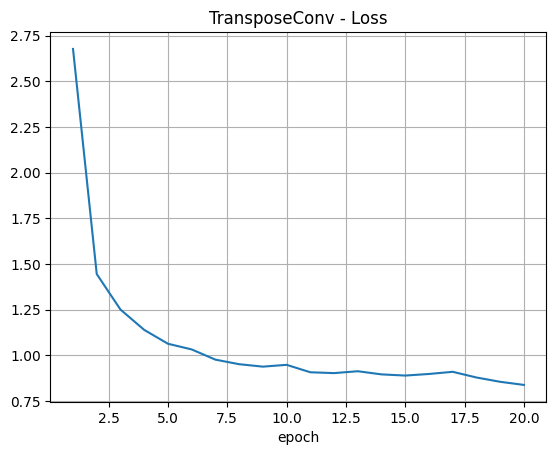

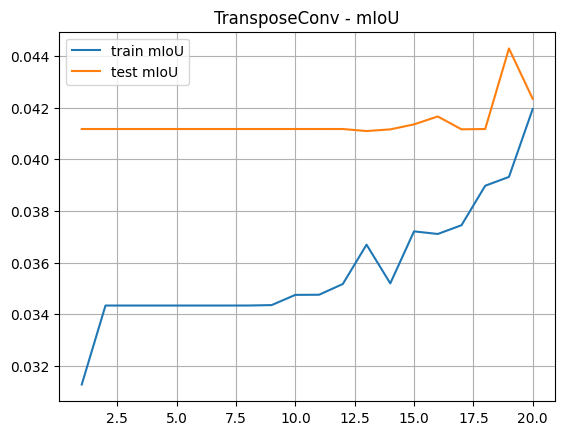

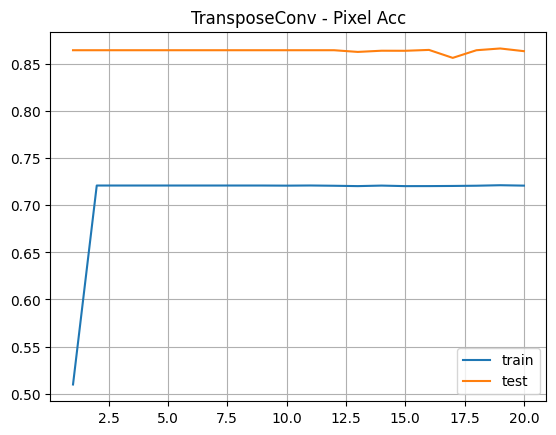

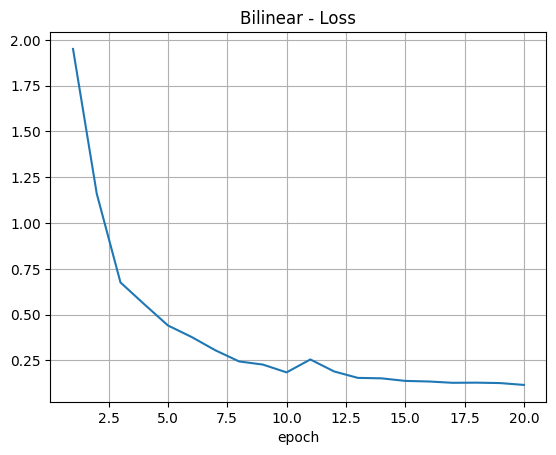

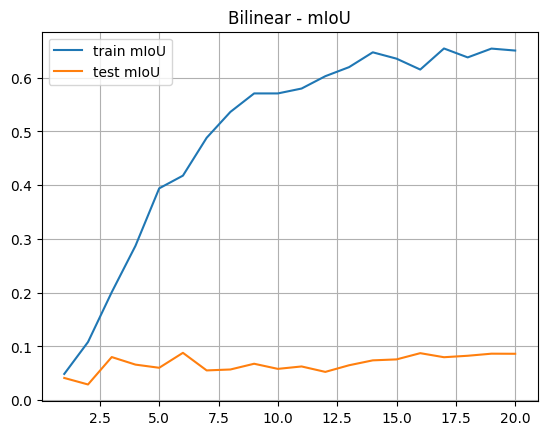

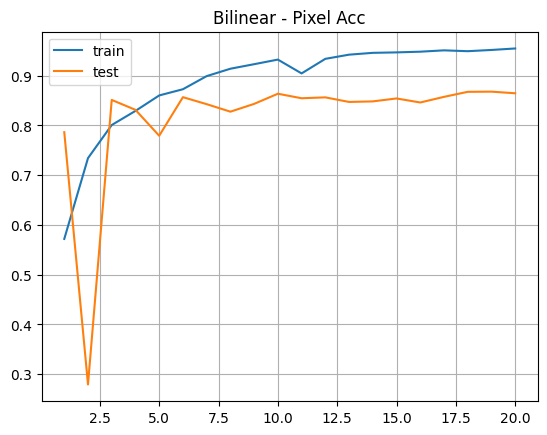

In [32]:
# ---------------------------
# 8) Plot training curves
# ---------------------------
def plot_history(h, title):
    epochs = list(range(1, len(h['train_loss'])+1))
    plt.figure(); plt.title(f'{title} - Loss'); plt.plot(epochs, h['train_loss']); plt.xlabel('epoch'); plt.grid(True); plt.show()
    plt.figure(); plt.title(f'{title} - mIoU'); plt.plot(epochs, h['train_mIoU'], label='train mIoU'); plt.plot(epochs, h['test_mIoU'], label='test mIoU'); plt.legend(); plt.grid(True); plt.show()
    plt.figure(); plt.title(f'{title} - Pixel Acc'); plt.plot(epochs, h['train_pixacc'], label='train'); plt.plot(epochs, h['test_pixacc'], label='test'); plt.legend(); plt.grid(True); plt.show()

plot_history(transpose_hist, 'TransposeConv')
plot_history(bilinear_hist,  'Bilinear')

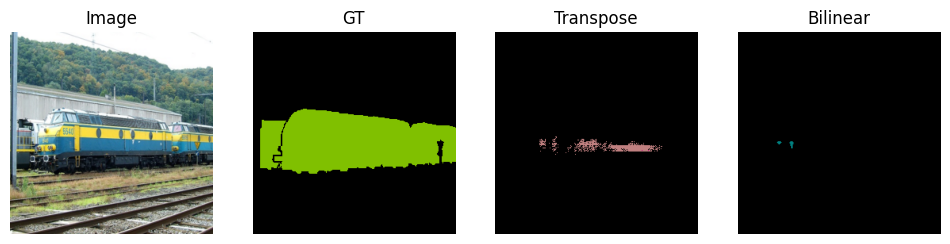

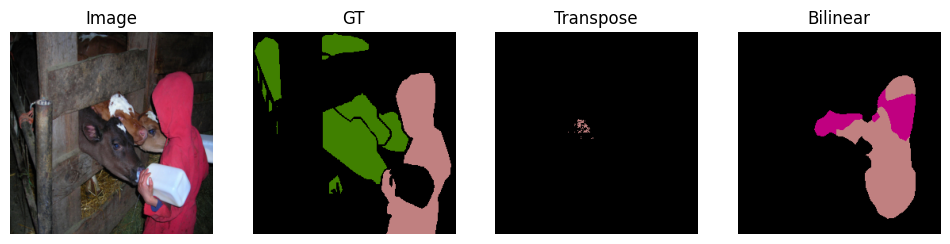

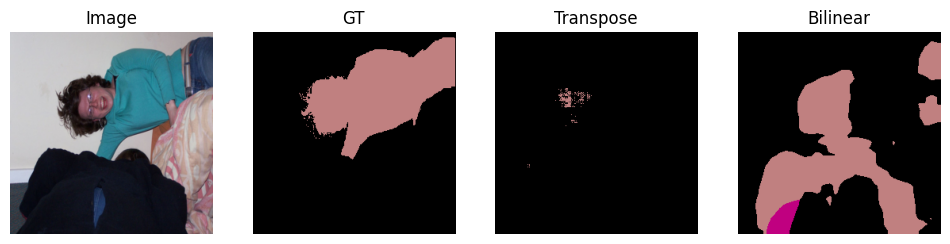

In [33]:
# ---------------------------
# 9) Qualitative visualization
# ---------------------------
palette = np.array([
    [0,0,0],[128,0,0],[0,128,0],[128,128,0],[0,0,128],[128,0,128],
    [0,128,128],[128,128,128],[64,0,0],[192,0,0],[64,128,0],[192,128,0],
    [64,0,128],[192,0,128],[64,128,128],[192,128,128],[0,64,0],[128,64,0],
    [0,192,0],[128,192,0],[0,64,128]
], dtype=np.uint8)

def decode_mask(mask):
    mask = np.asarray(mask, dtype=np.int32)
    return palette[mask % len(palette)]

@torch.no_grad()
def visualize_models(n_samples=3):
    transpose_model.eval(); bilinear_model.eval()
    shown = 0
    for x, y in test_loader:
        x = x.to(device); y = y.to(device)
        out_t = transpose_model(x); out_b = bilinear_model(x)
        p_t = out_t.argmax(1).squeeze(0).cpu().numpy()
        p_b = out_b.argmax(1).squeeze(0).cpu().numpy()
        gt = y.squeeze(0).cpu().numpy()

        # recover image for display
        img = x.squeeze(0).cpu()
        # unnormalize
        for c, m, s in zip(img, CFG.mean, CFG.std):
            c.mul_(s).add_(m)
        img = (img.clamp(0,1).permute(1,2,0).numpy()*255).astype(np.uint8)

        plt.figure(figsize=(12,3))
        plt.subplot(1,4,1); plt.title('Image'); plt.imshow(img); plt.axis('off')
        plt.subplot(1,4,2); plt.title('GT'); plt.imshow(decode_mask(gt)); plt.axis('off')
        plt.subplot(1,4,3); plt.title('Transpose'); plt.imshow(decode_mask(p_t)); plt.axis('off')
        plt.subplot(1,4,4); plt.title('Bilinear'); plt.imshow(decode_mask(p_b)); plt.axis('off')
        plt.show()

        shown += 1
        if shown >= n_samples:
            break

visualize_models(n_samples=3)

In [34]:
# ---------------------------
# 10) Comparison table
# ---------------------------
def summarize_history(h):
    return {
        'best_test_mIoU': float(np.max(h['test_mIoU'])) if len(h['test_mIoU'])>0 else 0.0,
        'final_test_mIoU': float(h['test_mIoU'][-1]) if len(h['test_mIoU'])>0 else 0.0,
        'best_test_pixel_acc': float(np.max(h['test_pixacc'])) if len(h['test_pixacc'])>0 else 0.0,
        'final_test_pixel_acc': float(h['test_pixacc'][-1]) if len(h['test_pixacc'])>0 else 0.0,
    }

summary = pd.DataFrame.from_dict({
    'TransposeConv': summarize_history(transpose_hist),
    'Bilinear': summarize_history(bilinear_hist),
}, orient='index')

display(summary)

,best_test_mIoU,final_test_mIoU,best_test_pixel_acc,final_test_pixel_acc
TransposeConv,0.044296,0.042348,0.866524,0.863667
Bilinear,0.088136,0.086361,0.867941,0.864679


Trained two FCN-8s models using a small subset (≈40 images) of the Pascal VOC 2012 dataset for 20 epochs to compare the effects of different upsampling methods. Both models showed convergence with decreasing training loss and stable pixel accuracy above 86%.

The Bilinear Interpolation variant achieved slightly higher mean Intersection-over-Union (mIoU ≈ 0.09 vs. 0.04) and comparable pixel accuracy, indicating smoother and more stable reconstructions during early training.

The Transpose Convolution version learned task-specific upsampling weights but showed minor overfitting and noisier predictions, likely due to the very small dataset size.

Qualitatively, both methods correctly highlight coarse object shapes but fail to delineate fine edges, as expected for such limited training.

Overall, bilinear interpolation provides a more robust baseline on small datasets, while transpose convolution could outperform with larger data and longer training.

Bilinear = safe, reliable baseline
Transpose Conv = learnable but riskier on small datasets